In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import confusion_matrix,classification_report

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.preprocessing import image

In [4]:
image_dir=Path('Food Classification')

Creating file dataframe 

In [7]:
filepaths=list(image_dir.glob(r'**/*.jpg'))
# using glob to target particular image files
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
# separating the class names from the file paths and saving it in the label 

filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')

images=pd.concat([filepaths,labels],axis=1)

category_samples=[]

for category in images['Label'].unique():
    category_slice=images.query("Label==@category")
    category_samples.append(category_slice.sample(130,random_state=1))
    
image_df=pd.concat(category_samples,axis=0).sample(frac=1.0 ,random_state=1).reset_index(drop=True)


In [10]:
image_df['Label'].value_counts()

Label
chai             130
pav_bhaji        130
idli             130
kadai_paneer     130
pizza            130
fried_rice       130
masala_dosa      130
burger           130
chole_bhature    130
kulfi            130
momos            130
samosa           130
chapati          130
jalebi           130
paani_puri       130
pakode           130
dhokla           130
dal_makhani      130
kaathi_rolls     130
butter_naan      130
Name: count, dtype: int64

train_test_split

In [11]:
train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)

In [14]:

# limited memory so we train in batches to reduce memory

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,validation_split=0.2)


test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [19]:
# This image will pass to our activation function or fit function

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224)
)
# default image size for our mobilevnet model is 224 * 224

color_mode='rgb'
class_mode='categorical',
batch_size=32,
shuffle=True,
# shuffle after each epoch
seed=42,
subset='training'

# using validation split 

validation_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

    
    

Found 1819 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


modeling

In [24]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    # we dont waana keep thr classfication layer of the dataset on which model is pretrained
    # we will inclide orignally trained on imagenet dataset 1000 classes
    weights='imagenet',
    # to keep the same weights
    pooling='avg',
)
    # output is now 1d
pretrained_model.trainable= False
    


9406464/9406464 [==============================] - 4s 0us/step


In [25]:
inputs=pretrained_model.input

x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
# 128 neurons
x=tf.keras.layers.Dense(128,activation='relu')(x)

outputs=tf.keras.layers.Dense(20,activation='softmax')(x)
model=tf.keras.Model(inputs,outputs)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

training

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='validation_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
57/57 [==============================] - 56s 914ms/step - loss: 1.7780 - accuracy: 0.4882 - val_loss: 0.7302 - val_accuracy: 0.7934
Epoch 2/10
57/57 [==============================] - 50s 879ms/step - loss: 0.6657 - accuracy: 0.8131 - val_loss: 0.4048 - val_accuracy: 0.8926
Epoch 3/10
57/57 [==============================] - 47s 835ms/step - loss: 0.3910 - accuracy: 0.8994 - val_loss: 0.2621 - val_accuracy: 0.9421
Epoch 4/10
57/57 [==============================] - 48s 840ms/step - loss: 0.2410 - accuracy: 0.9379 - val_loss: 0.1485 - val_accuracy: 0.9780
Epoch 5/10
57/57 [==============================] - 48s 845ms/step - loss: 0.1438 - accuracy: 0.9720 - val_loss: 0.0872 - val_accuracy: 0.9945
Epoch 6/10
57/57 [==============================] - 49s 858ms/step - loss: 0.0893 - accuracy: 0.9863 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 7/10
57/57 [==============================] - 49s 868ms/step - loss: 0.0490 - accuracy: 0.9967 - val_loss: 0.0241 - val_accuracy: 1.0000

results

In [27]:
 # model.save('food_classification.h5')
results=model.evaluate(test_images,verbose=0)
print("Test Accuracy: {:2f}%".format(results[1]*100))

Test Accuracy: 80.665815%


In [29]:
predictions=np.argmax(model.predict(test_images),axis=1)
cm=confusion_matrix(test_images.labels,predictions)
clr=classification_report(test_images.labels,predictions,target_names=test_images.class_indices, zero_division=0)

25/25 [==============================] - 19s 753ms/step


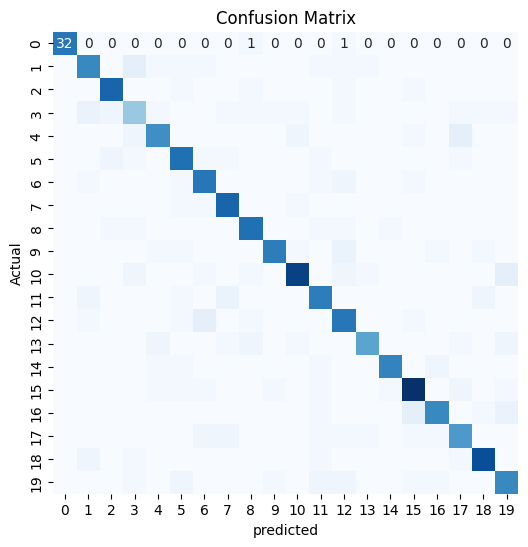

In [31]:
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5,label=test_images.class_indices,rotation=90)
plt.xticks(ticks=np.arange(20) + 0.5,label=test_images.class_indices,rotation=0)
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
print("Classification Report \n ----------------------------------\n",clr)

Classification Report 
 ----------------------------------
                precision    recall  f1-score   support

       burger       1.00      0.94      0.97        34
  butter_naan       0.76      0.74      0.75        39
         chai       0.88      0.90      0.89        39
      chapati       0.59      0.55      0.57        31
chole_bhature       0.80      0.76      0.78        37
  dal_makhani       0.75      0.82      0.79        40
       dhokla       0.74      0.84      0.79        38
   fried_rice       0.81      0.92      0.86        38
         idli       0.82      0.87      0.85        38
       jalebi       0.91      0.79      0.85        39
 kaathi_rolls       0.87      0.79      0.83        52
 kadai_paneer       0.74      0.79      0.77        39
        kulfi       0.68      0.80      0.74        40
  masala_dosa       0.89      0.73      0.80        33
        momos       0.94      0.86      0.90        35
   paani_puri       0.81      0.83      0.82        53
    

In [34]:
import cv2
# Replace this list with your actual class labels used during training
class_labels = image_df['Label']
img=cv2.imread('010.jpg')
img= cv2.resize(img, (224,224))
def preprocess_image(img):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

img=preprocess_image(img)
predictions=model.predict(img)
print(class_labels[np.argmax(predictions)])
print(class_labels)

1/1 [==============================] - 1s 1s/step
dal_makhani
0               chai
1          pav_bhaji
2       kaathi_rolls
3        dal_makhani
4          pav_bhaji
            ...     
2595      fried_rice
2596          dhokla
2597            idli
2598     butter_naan
2599            idli
Name: Label, Length: 2600, dtype: object


In [35]:
# Exporting Class labels
import pandas as pd
df=pd.DataFrame(class_labels)
label=df['Label']
label

0               chai
1          pav_bhaji
2       kaathi_rolls
3        dal_makhani
4          pav_bhaji
            ...     
2595      fried_rice
2596          dhokla
2597            idli
2598     butter_naan
2599            idli
Name: Label, Length: 2600, dtype: object

In [36]:
model.save('final_food_classifier.h5')

C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
